In [14]:
import random
import pandas as pd
import numpy as np
import scanpy as sc
from scipy import signal
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', None)

def get_normed_and_zero_filtered_data(filename):
    # TODO perhaps include other normalization options
    df = pd.read_csv(filename, sep = '\t', index_col = 0)
    df = df / df.mean()
    df = df.loc[df.sum(axis=1) != 0,:]
    df = (df
          .assign(sum=df.sum(axis=1))
          .sort_values(by='sum', ascending=False)
          .drop('sum', axis = 1)
         )
    return df

def get_s745_time(names):
    return [float(el.split('_')[1]) for el in names]

def get_s814_time(names):
    return [ 6.25 * float(el.split('_')[0][-2:]) for el in names]

def get_s800_time(names):
    return [ 6.25 * float(el.split('_')[1][-2:]) for el in names]

def get_periodgram(sc_data):
    return [signal.periodogram(sc_data.X[:,i]) for i in range(sc_data.shape[1])]

def plot_one_row_line(df, row_num):
    df.iloc[row_num,:].plot.line()
    
def plot_one_row_scatter(df, row_num, time):
    plt.scatter(df.iloc[row_num,:], time)
    
def dist(x, y):
    # TODO normed difference
    x = x/np.linalg.norm(x)
    y = y/np.linalg.norm(y)
    
    return (x-y).T@(x-y)


"""
    this implementation of k-means takes as input (i) a matrix pd
    with the data points as rows (ii) an integer K representing the number 
    of clusters, and returns (i) a matrix with the K rows representing 
    the cluster centers 
    """
def k_means_from_pd_data(pd, K, maxIters = 300):
   
    centroids = pd[np.random.choice(pd.shape[0], K, replace=False)]
    old_centroids = centroids.copy()
    for i in range(maxIters):
        # Cluster Assignment step
        C = np.array([np.argmin([dist(x_i, y_k) for y_k in centroids]) for x_i in pd])
        # Update centroids step
        for k in range(K):
            if (C == k).any():                
                centroids[k] = pd[C == k].mean(axis = 0) 
            else: # if there are no data points assigned to this certain centroid
                centroids[k] = pd[np.random.choice(len(pd))] 
        if np.array_equal(centroids, old_centroids):
            print(f'converged on iter: {i}')
            break
        old_centroids = centroids.copy()
    return C, centroids

def add_top_n_expressed_label_to_var(data,top_n):
    cutoff = sorted(data.var.n_counts, reverse=True)[top_n]

    for i in range(0, data.var.shape[0]):
        if data.var.iloc[i,:].n_counts > cutoff:
            data.var.loc[data.var.index[i], 'top_n_expressed'] = True
        else:
            data.var.loc[data.var.index[i], 'top_n_expressed'] = False
    
def drop_description(old_file, new_file):
    df = pd.read_csv(old_file, sep='\t', index_col=0)
    df = df.drop(['description'], axis=1)
    df.to_csv(new_file, sep='\t')

    
    
def preprocessing (adata, n_expressed=200):
    sc.pp.filter_genes(adata, min_counts=1)
    sc.pp.normalize_total(adata, target_sum=1e6, exclude_highly_expressed=False)
    sc.pp.log1p(adata)
    


    add_top_n_expressed_label_to_var(adata,n_expressed)

    return adata, adata[:,adata.var.top_n_expressed.isin([True])]



def get_mutual_periodgram_genes(adata_miRNA, target_miRNA, adata_mRNA, n_closest=50):
   
    pd_array_mi = np.array([i[1] for i in get_periodgram(adata_miRNA)])
    pd_array_m = np.array([i[1] for i in get_periodgram(adata_mRNA)])
    
    position = list(adata_miRNA.var.index).index(target_miRNA)

    adata_mRNA.var['dist'] = np.nan
    for i in range(len(pd_array_m)):
        adata_mRNA.var.loc[adata_mRNA.var.index[i], 'dist'] = dist(pd_array_mi[position],pd_array_m[i])
    
    cutoff = sorted(adata_mRNA.var.dist, reverse=False)[n_closest]
    clost_dist = adata_mRNA[:, adata_mRNA.var.dist < cutoff]
    return clost_dist.var

In [10]:
# We have 4 data sets, consisting of two paired mRNA-miRNA timecourses.
# Sub_0745: miRNA 12.5m timepoints (Actually has two repeated data sets, which we will split)
# Sub_0743: mRNA 12.5
# Sub_0814: miRNA
# Sub_0800: mRNA

s745_adata = sc.read("data/sub_0745_miRNA.ec.tab").T
s743_adata = sc.read("data/s743.tab").T
s800_adata = sc.read("data/s800.tab").T
s814_adata = sc.read("data/sub_0814_miRNA.ec.tab").T

# Note: the mRNA .tab files were earlier preprocessed to drop description col
# consider moving that here?
# drop_description("data/sub_0743.genes.no_mt.tpm.rescale.tab", "data/s743.tab")

# We pull times out of the sample names

s800_adata.obs['time'] = get_s800_time(s800_adata.obs.index)
s814_adata.obs['time'] = get_s814_time(s814_adata.obs.index)
s743_adata.obs['time'] = get_s745_time(s743_adata.obs.index)
s745_adata.obs['time'] = get_s745_time(s745_adata.obs.index)

# Split up the 745 runs

s745_adata_first_run = s745_adata[::2]
s745_adata_second_run = s745_adata[1::2]

In [11]:

# Our Preprocessing steps include:
#     Filter out genes with counts < 1
#     Normalize counts to 1e6 (Not TPM!)
#     Logp1 
#     Add a boolean label for each gene - top_n_expressed (default  200) 
#         There are many fewer expressed miRNA, so we use 50 for those. 
# Return both the entire preprocessed data and a top_n only view

s814_adata, s814_top = preprocessing(s814_adata, n_expressed=50)
s800_adata, s800_top = preprocessing(s800_adata)


s745_1_adata, s745_1_top = preprocessing(s745_adata_first_run, n_expressed=50)
s745_2_adata, s745_2_top = preprocessing(s745_adata_second_run, n_expressed=50)
s743_adata, s743_top = preprocessing(s743_adata)



/Users/jsteill/bin/Virt_Py_Envs/jlab2/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [20]:
# We are looking for mRNA genes which cycle similarly to a target miRNA. 
# Our strategy is to calculate the periodogram for the target miRNA, and all genes. Sort by distance, and return n closest. 
# Hopefully we'll see some overlap in out 3 pairs of data. 

n_closest = 75
s800_closest_genes= get_mutual_periodgram_genes(
    adata_miRNA=s814_top, 
    target_miRNA='hsa-miR-10a-5p', 
    adata_mRNA=s800_top,
    n_closest = n_closest
)

s743_1_closest_genes= get_mutual_periodgram_genes(
    adata_miRNA=s745_1_top, 
    target_miRNA='hsa-miR-10a-5p', 
    adata_mRNA=s743_top,
    n_closest = n_closest
)

s743_2_closest_genes= get_mutual_periodgram_genes(
    adata_miRNA=s745_2_top, 
    target_miRNA='hsa-miR-10a-5p', 
    adata_mRNA=s743_top,
    n_closest = n_closest
)




#none of them are defined target for hsa-miR-10a-5p based on miRDA database

set(s800_closest_genes.index)&set(s743_1_closest_genes.index)&set(s743_2_closest_genes.index)





set()

In [25]:
K = 6
C, centroids = k_means_from_pd_data(s814_pd_array,K)

print('C = \n', C)

converged on iter: 5
C = 
 [2 1 5 1 1 3 3 5 5 1 1 0 0 1 0 4 2 1 2 4 4 0 2 1 5 0 5 4 3 4 5 0 4 5 1 0 3
 1 0 1 1 3 5 0 5 1 1 2 4 2]


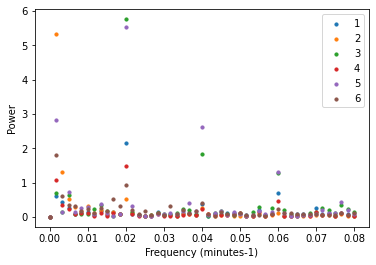

0.01

In [26]:

#matplotlib.pyplot.scatter(s814_pd[0][0],centroids_2[1])
fig = plt.figure()
ax1 = fig.add_subplot(111)

for i in range(K):
    ax1.scatter(s814_pd[0][0]/6.25,centroids[i], s=10, label=i+1)
    
    

plt.xlabel('Frequency (minutes-1)')
plt.ylabel('Power')

plt.legend();
plt.show();
1/(12.5 * 8 )


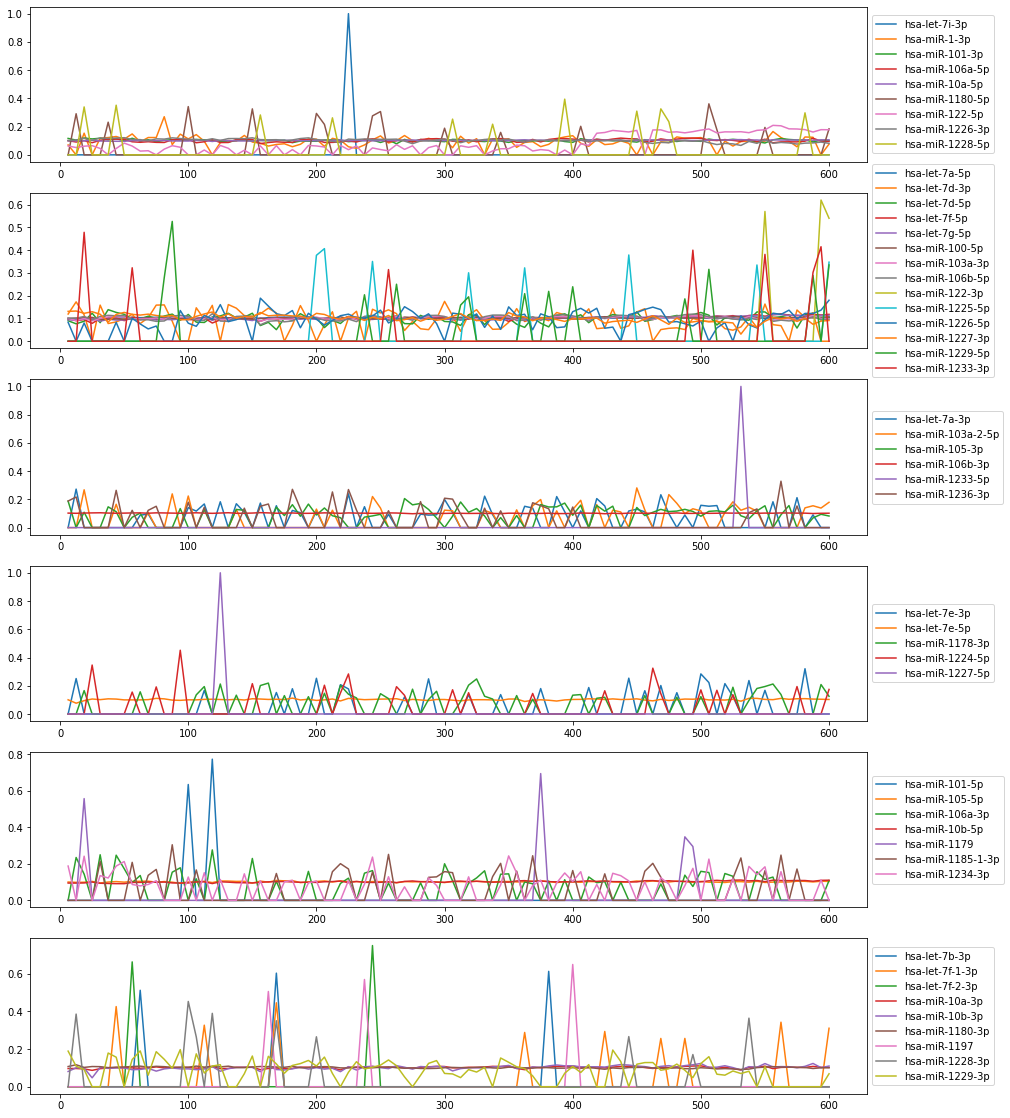

In [27]:

fig, axs = plt.subplots(K,1, figsize=(15,20))

time = s814_adata.obs.time

for i_k in range(K):
    for i in range(len(C)):
        if C[i]==i_k:
            y = s814_adata.X[:,i]
            axs[i_k].plot(time,y/np.linalg.norm(y), label=s814_adata.var.index[i].split(',')[0])
            axs[i_k].legend(loc='center left', bbox_to_anchor=(1, 0.5))
   
#plt.ylabel('Power')

#plt.legend();
#plt.show();

#for i in range(10):
   # matplotlib.pyplot.scatter(s814_pd[i][0], np.log(s814_pd[i][1]+1))

In [28]:
print(s814_clodis_gene)

           n_counts top_n_expressed      dist
CALM2    672.031494            True  0.131248
CANX     658.957581            True  0.174711
CCT2     641.619568            True  0.221439
DACT1    645.468262            True  0.168068
DDX5     644.617676            True  0.228828
EIF5A    684.903564            True  0.195389
FABP5    708.950928            True  0.255914
GAPDH    706.726685            True  0.191830
GJA1     721.779419            True  0.173078
HNRNPA3  691.817627            True  0.298100
HNRNPC   664.897278            True  0.217809
HNRNPD   724.305542            True  0.298300
HNRNPK   666.701538            True  0.268511
HNRNPR   694.394897            True  0.153624
HNRNPU   640.519409            True  0.237033
HSPA5    647.931641            True  0.280732
HSPD1    715.673828            True  0.173996
ILF2     636.972961            True  0.267552
KPNB1    638.180054            True  0.133840
LDHA     724.760620            True  0.125843
LMNB1    661.553101            Tru

Trying to set attribute `.var` of view, copying.


            n_counts top_n_expressed      dist
COL1A2    677.180542            True  0.008609
CTHRC1    646.095093            True  0.015814
DBN1      650.049072            True  0.063415
DLL1      833.599182            True  0.136747
DNAJA1    642.939697            True  0.014391
EEF1B2    685.188354            True  0.032118
EEF2      725.747253            True  0.094780
EIF4A2    652.306213            True  0.015964
FABP5     656.730469            True  0.052841
FDPS      673.030151            True  0.019853
FTL       672.846497            True  0.091357
H2AFZ     657.734253            True  0.031006
HMGB1     702.315552            True  0.076775
HMGB2     743.402588            True  0.053162
HMGCS1    719.585693            True  0.075481
HNRNPD    694.457458            True  0.082529
HNRNPH1   719.047119            True  0.022052
HNRNPM    707.330078            True  0.035776
HSP90B1   749.931580            True  0.027817
HSPA5     664.556396            True  0.087786
HSPA8     713

            n_counts top_n_expressed      dist
ANP32B    707.155579            True  0.760130
APP       656.043457            True  0.730840
BTF3      665.485229            True  0.699076
CCT8      646.423340            True  0.739261
CLIC1     652.062134            True  0.810595
CSDE1     655.228394            True  0.354199
EEF1D     641.081299            True  0.530176
EIF4A1    710.598206            True  0.808347
GAPDH     780.768921            True  0.725942
HSP90AA1  782.108643            True  0.788923
ILF2      642.314331            True  0.775097
MDK       701.860352            True  0.701696
NONO      668.355835            True  0.665623
PABPC1    847.687439            True  0.292460
PCBP2     643.208557            True  0.565603
PTMA      818.837280            True  0.815615
PTMS      646.738647            True  0.396509
RPL13A    802.795410            True  0.600830
RPL14     671.040527            True  0.747079
RPL17     682.298950            True  0.802345
RPL21     687

set()

In [47]:
K = 6
C, centroids = k_means_from_pd_data(s745_pd_array_first_run,K)

print('C = \n', C)


converged on iter: 8
C = 
 [3 0 3 2 2 2 4 3 2 2 2 2 5 1 3 1 2 2 0 2 2 2 4 3 1 3 0 3 0 2 5 2 4 0 4 2 2
 0 4 4 4 4 3 4 2 4 1 2 4 5 5 1 1 2 5 1 5 4 5 3 2 4 2 1 2 2 2 2 3 3 5 1 0 1
 3 1 2 4 2 1 2 2 0 4 3 5 2 3 2 4 2 2 2 1 4 2 0 2 5 2 3 5 2 4 2 2 0 0 3 2 2
 0 2 2 2 3 1 1 2 5 2 2 1 1 5 0 2 3 1 3 2 5 3 1 5 5 5 2 2 2 2 2 2 2 3 3 3 5
 3 4 0 3 4 2 5 2 5 2 2 2 1 2 0 1 4 5 1 2 2 1 2 5 3 2 3 0 2 4 0 2 2 0 3 4 2
 0 4 0 3 2 1 2 2 2 5 4 2 4 3 3]


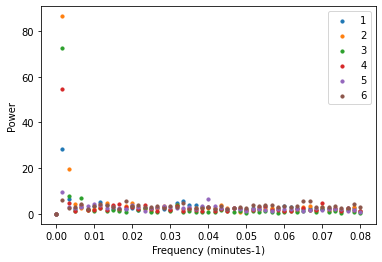

0.01

In [48]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

for i in range(K):
    ax1.scatter(s745_pd_first_run[0][0]/6.25,centroids[i], s=10, label=i+1)
    
    

plt.xlabel('Frequency (minutes-1)')
plt.ylabel('Power')

plt.legend();
plt.show();
1/(12.5 * 8 )